# About
This notebook aims to develop models for predicting whether a customer will buy a certain item (`itemOne`) given historical customer data.

## Problem approach 
The dataset describes features of customers, $x$, such as historical behavior in interacting with the store or preferences for items. The target variable $y$ is also given, what the customer actually bought in the last store visit. Here this is solved as a classification problem, where the goal is to make a model mapping $x$ to $y$, where $y$ is a binary variable (true/false).

# Basic imports, setup

In [1]:
import os
import sys
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn

In [2]:
sns.set_style("whitegrid")

# Load and merge datasets

In [3]:
customer_scores_file = "./cust.csv"
customer_status_file = "./main.csv"

df_scores = pd.read_csv(customer_scores_file, sep=';')
df_status = pd.read_csv(customer_status_file, sep=';')

In [5]:
assert df_scores.isna().sum().sum() == 0
assert df_status.isna().sum().sum() == 0

## Customer preference scores dataset
This data contains score of customer preferences, a score set somehow by prior shopping statistics. Presumably, if a user has a $x$ times higher score on item one, it means that it likes/will be $x$ times more likely to buy item 1. 

In [6]:
df_scores

,cust_id,pref,score
0,0,preferenceItemOneTwoThree,48.15
1,0,preferenceItemOne,25.93
2,1,preferenceItemOneTwoThree,50.98
3,1,preferenceItemOne,23.53
4,2,preferenceItemOneTwoThree,41.18
...,...,...,...
7355,3677,preferenceItemOne,40.00
7356,3678,preferenceItemOneTwoThree,76.32
7357,3678,preferenceItemOne,42.11
7358,3679,preferenceItemOneTwoThree,65.79


In [7]:
# Some checks:
# Each customer has a score for each preference category
print(df_scores.groupby('cust_id').count().value_counts())

pref  score
2     2        3680
dtype: int64


## Customer status dataset
This dataset contains the status of the customer when entering the store. These are the descriptions of the 31 variables, including the target variable *bought_item* and excluding the customer id*cust_id* linking to the customer scores.

- *model1*	 customer statistics
- *model2*	 customer statistics
- *boughtItemsTotal*	 total number of items bought	
- *itemOneTotal*	 total number of times item one is bought	
- *itemTwoTotal*	 total number of times item two is bought	
- *itemThreeTotal*	 total number of times item three is bought	
- *Visits2014*	 number of store visits in 2014	
- *itemOneTotal2014*	 total number of times item one is bought in 2014	
- *itemTwoTotal2014*	 ""	
- *itemThreeTotal2014*	 ""	
- *Visits2013*	 ""	
- *itemOneTotal2013*	 "" 	
- *itemTwoTotal2013*	 ""	
- *itemThreeTotal2013*	 ""	
- *boughtItem_03* bought item in the last 3 visit	
- *boughtItem_02* bought item in the last 2 visit	
- *boughtItem_01* bought item in the last 1 visit	
- *date_lastVisit*	 date for last visit 	
- *daysSinceVisit*	 days since last visit	
- *boughtItem*	 bought item (**target variable**) (= the item bought by the customer at this particular visit)
- *numVisitsL1M*	 number of visits last 1 month	
- *numVisitsL3M*	 ""	
- *numVisitsL6M*	 ""	
- *numVisits_trendL3M*	 trend for visit frequency last 3 months	
- *fractionItemOneL1M*	 fraction of visits that customer bought item one last 1 month	
- *fractionItemOneTwoThreeL1M*	 fraction of visits that customer bought item one two or three last 1 month	
- *fractionItemOneL3M*	 ""	
- *fractionItemOneTwoThreeL3M*	 "" 	
- *fractionItemOneL6M*	 ""	
- *fractionItemOneTwoThreeL6M*	 "" 	
- *numItemOne_trendL3M* 	trend for buying item one	

**Note:** some of these are unclear to me what they "really" mean. For instance: the description of *boughtItem_03* "bought item in the last 3 visit" a categorical variable '1', '2', etc., referring to diferent items labels. Does it mean that item was bought 3 visits back? Or does it refer to the most common item in 3 last visits? Also there is no info about what the models are.

In [8]:
df_status

,cust_id,model1,model2,boughtItemsTotal,itemOneTotal,itemTwoTotal,itemThreeTotal,Visits2014,itemOneTotal2014,itemTwoTotal2014,...,numVisitsL3M,numVisitsL6M,numVisits_trendL3M,fractionItemOneL1M,fractionItemOneTwoThreeL1M,fractionItemOneL3M,fractionItemOneTwoThreeL3M,fractionItemOneL6M,fractionItemOneTwoThreeL6M,numItemOne_trendL3M
0,0,3,190,24,7,4,2,4,2,0,...,4,8,1.000000,0.000000,0.000000,0.500000,0.500000,0.375000,0.500000,1.333333
1,1,1,280,49,12,5,8,2,1,1,...,2,7,0.400000,1.000000,1.000000,0.500000,1.000000,0.285714,0.714286,1.750000
2,2,2,254,27,6,6,1,5,1,1,...,4,10,0.666667,0.000000,0.500000,0.000000,0.250000,0.200000,0.600000,0.000000
3,3,0,464,43,12,6,3,7,1,1,...,6,10,1.500000,0.000000,0.000000,0.166667,0.500000,0.100000,0.300000,1.666667
4,4,6,116,28,11,5,2,7,2,1,...,6,7,6.000000,0.500000,0.500000,0.333333,0.500000,0.285714,0.571429,1.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3675,3675,2,484,57,8,9,11,9,0,1,...,4,10,0.666667,0.000000,0.000000,0.000000,0.500000,0.000000,0.500000,0.000000
3676,3676,8,101,36,12,9,2,5,2,1,...,3,7,0.750000,0.000000,1.000000,0.333333,1.000000,0.285714,0.714286,1.166667
3677,3677,3,137,71,30,13,6,7,3,2,...,5,7,2.500000,0.000000,0.000000,0.200000,0.600000,0.428571,0.714286,0.466667
3678,3678,23,34,32,15,9,3,6,1,4,...,6,6,0.000000,0.000000,0.500000,0.166667,0.833333,0.166667,0.833333,1.000000


## Merge dataframes
Add the preference data from *cust.csv* into the main dataframe.

In [9]:
# Merge on cust_id and then drop this column
df = df_status.merge(df_scores.pivot(index='cust_id', columns='pref', values='score').reset_index(), on='cust_id').drop(columns=['cust_id'])

In [10]:
# Subtract 2 for join-column dropped for both dataframes
assert df.shape[1] == df_status.shape[1] + df_scores.shape[1] - 2

# Data exploration and visualization
Here I plot distributions of the data in relation to the target variable. I also make some basic data transformations.

## Target variable

We want to predict whether a customer buys "itemOne", i.e. wheterh *boughtItem* equals '1'.

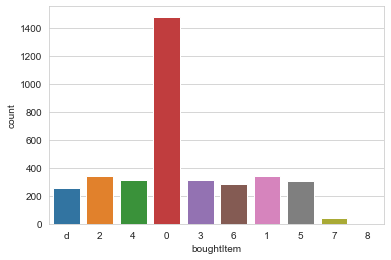

In [11]:
sns.countplot(data=df, x='boughtItem');

Perhaps '0' here corresponds to not having bought an item? Here, we are only interested in predicting whether item '1' was bought, so make this categorical variable binary (0 corresponds to not buying itemOne, 1 corresponds to buying itemOne).

In [12]:
# Target to be used for modeling
target = 'boughtItemOne'

In [13]:
df[target] = df['boughtItem'] == '1'

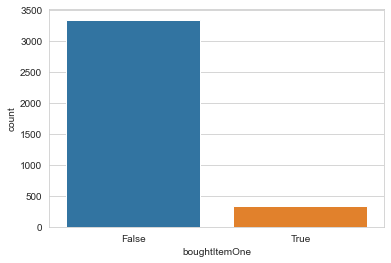

In [14]:
sns.countplot(data=df, x=target);

It's clear from the target variable distribution that this is an imbalanced dataset. The ratio of of false to true is roughly 10:1:

In [15]:
# Baseline ~9% probability of buying item 1.
df[target].mean()

0.09239130434782608

In [16]:
df[target].value_counts()

False    3340
True      340
Name: boughtItemOne, dtype: int64

## Features relation to the target

To get a feeling for the data I split the variables into 6 groups that seem natural and visualize them separately below. These are:
1. Model-based (2 variables)
2. Counts of items bought (10)
3. Visit counts (8)
4.  Fractions of having bought certain items, including the trend for buying item one (7)
5. Preferences for certain items (2)
6. Items bought in past visits (3)

In total there are **32 input variables**.

Below the distributions of the variables are visualized, and color-coded according to the (binary) target variable.

In [17]:
def plot_distributions(df, cols, size=4):
    num_cols = len(cols)
    num_plots = 4
    bins = 10
    # Features column-wise, differnt plot types row-wise
    fig, axes = plt.subplots(num_plots, num_cols, figsize=(num_cols*size, num_plots*size), sharey='row') 

    if len(axes.shape) == 1:
        axes = np.array([axes]).reshape((-1,1))

    # Loop over cols
    for c, ax_col in zip(cols, axes.T):
        discrete = df[c].nunique() < bins
        plot_discrete = discrete
        binwidth = None
        # Tweak binning for few number of unique values
        if discrete:
            if df[c].dtype == 'float':
                # Seaborn's `discrete` arg sets binwidth = 1.
                # For few non-integer values (like fractions) this makes more sense.
                plot_discrete = False
                max_gap = max(np.diff(sorted(df[c].unique())))
                binwidth = max_gap*1.01
        # TODO: fix/organize input args better, clean up different cases
        
        categorical = df[c].dtype.name == "category"
        if categorical:
            discrete = False

        # Stack distributions
        ax = ax_col[0]
        if discrete:
            sns.histplot(ax=ax, data=df, x=c, hue=target, multiple='stack', element='bars', common_norm=True, stat='count', kde=False, discrete=plot_discrete, binwidth=binwidth)
        elif categorical:
            sns.histplot(ax=ax, data=df, x=c, hue=target, multiple='stack')        
        else:
            sns.histplot(ax=ax, data=df, x=c, hue=target, multiple='stack', element='step', common_norm=True, stat='count', kde=False, bins=bins, discrete=False)

        # Normalize separately
        ax = ax_col[1]
        if discrete:
            sns.histplot(ax=ax, data=df, x=c, hue=target, multiple='dodge', element='bars', common_norm=False, stat='probability', kde=False, fill=True, discrete=plot_discrete, binwidth=binwidth)
        elif categorical:            
            sns.histplot(ax=ax, data=df, x=c, hue=target, multiple='dodge', stat="probability", common_norm=False)
        else:
            sns.histplot(ax=ax, data=df, x=c, hue=target, multiple='layer', element='step', common_norm=False, stat='probability', kde=False, bins=bins, fill=True, discrete=False)
            
        # Distributions normalized per bin
        ax = ax_col[2]
        if discrete:
            sns.histplot(ax=ax, data=df, x=c, hue=target, multiple='fill', element='bars', common_norm=False, stat='probability', kde=False, fill=True, discrete=plot_discrete, binwidth=binwidth)
        elif categorical:
            sns.histplot(ax=ax, data=df, x=c, hue=target, multiple='fill')
        else:
            sns.histplot(ax=ax, data=df, x=c, hue=target, multiple='fill', element='step', common_norm=False, stat='probability', kde=False, bins=bins, fill=True, discrete=False)
            
        # Target averaged over quantiles (normalized per quantile)
        if not categorical:
            ax = ax_col[3]
            plot_mean_quantiled(df, c=c, target=target, ax=ax)

In [18]:
def plot_mean_quantiled(df, c, target, num_quantiles=4, ax=None, static_ylims=True):
    cq = c+'_quantiled'
    # For discrete variables, it may be impossible to find the number of requested quantiles,
    # accept and take the number that works.
    cq_series =   pd.qcut(df[c], num_quantiles, duplicates='drop').rename(cq)
    df_cq = pd.concat([df[target], cq_series], axis=1)
    sns.pointplot(data=df_cq.groupby(cq)[target].mean().reset_index().rename(columns={target: target+'_mean'}), 
                  x=cq, y=target+'_mean', kind='point', ax=ax)
    if static_ylims:
        # Heuristically set ylims independently of what columns are plotted
        ymin = round(df[target].mean()/3, ndigits=1)
        ymax = round(df[target].mean()*3, ndigits=1)
        ax.set_ylim(ymin, ymax)

### 1. Model-based
Integer-valued.

In [19]:
cols = ['model1', 'model2']
model_cols = cols
print(len(cols))
cols

2


['model1', 'model2']

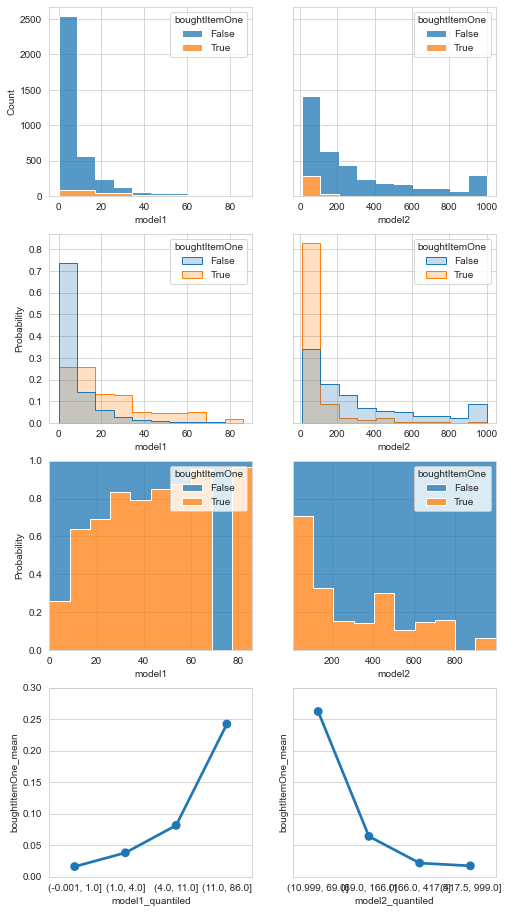

In [20]:
plot_distributions(df, cols)

* Both models have different distributions conditional on having bought itemOne or not, indicating that they may be predictive:
    * Larger values of *model1* correlates with higher probability of buying itemOne.
    * Smaller values of *model2* correlates with higher probability of buying itemOne.

### 2. Counts of items bought
Also integers.

In [21]:
cols = [c for c in df.columns if 'total' in c.lower()]
count_cols = cols
print(len(cols))
cols

10


['boughtItemsTotal',
 'itemOneTotal',
 'itemTwoTotal',
 'itemThreeTotal',
 'itemOneTotal2014',
 'itemTwoTotal2014',
 'itemThreeTotal2014',
 'itemOneTotal2013',
 'itemTwoTotal2013',
 'itemThreeTotal2013']

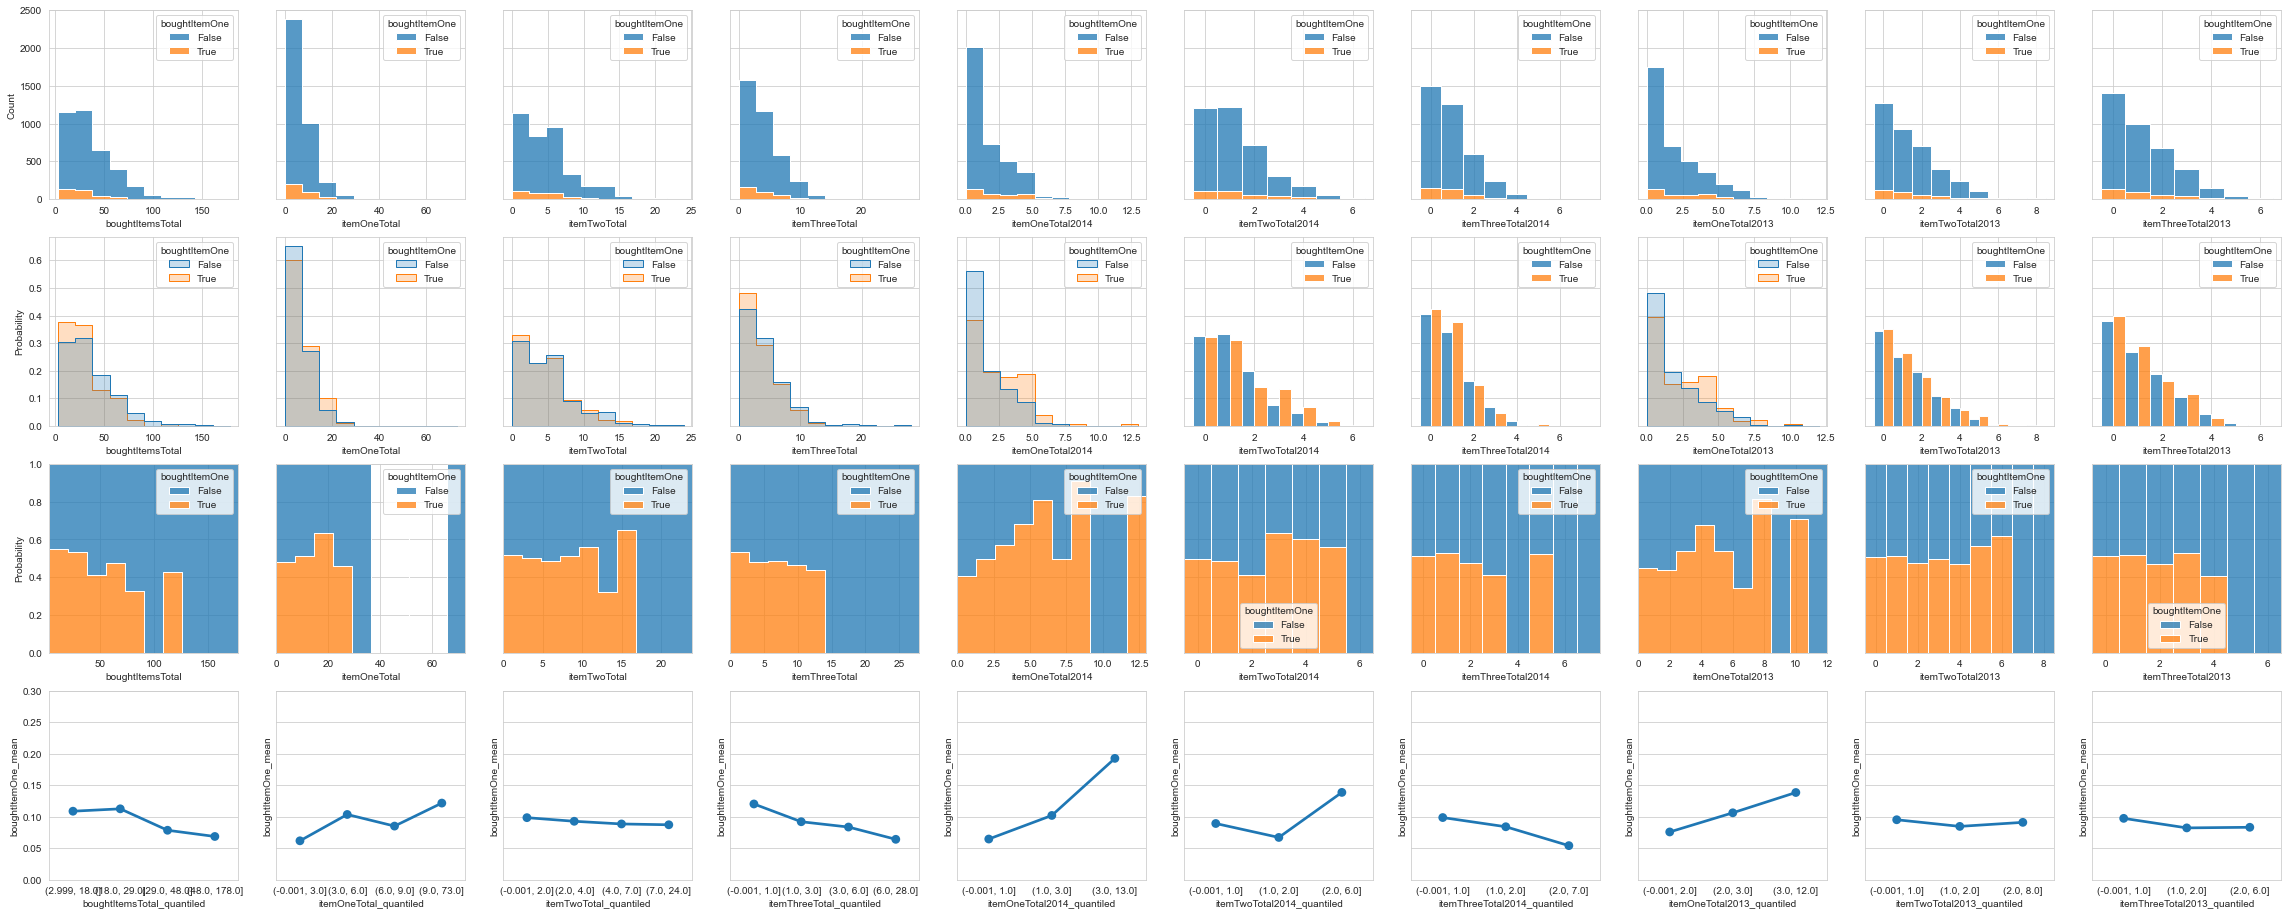

In [22]:
plot_distributions(df, cols)

* The distributions of the count variables conditioned on having or not buying itemOne are fairly similar. *ItemOneTotal2013* and *ItemOneTotal2014* show slight differences between distributions.

### 3. Counts of visits

In [23]:
cols = [c for c in df.columns if 'visit' in c.lower()]
visit_cols = cols
print(len(cols))

8


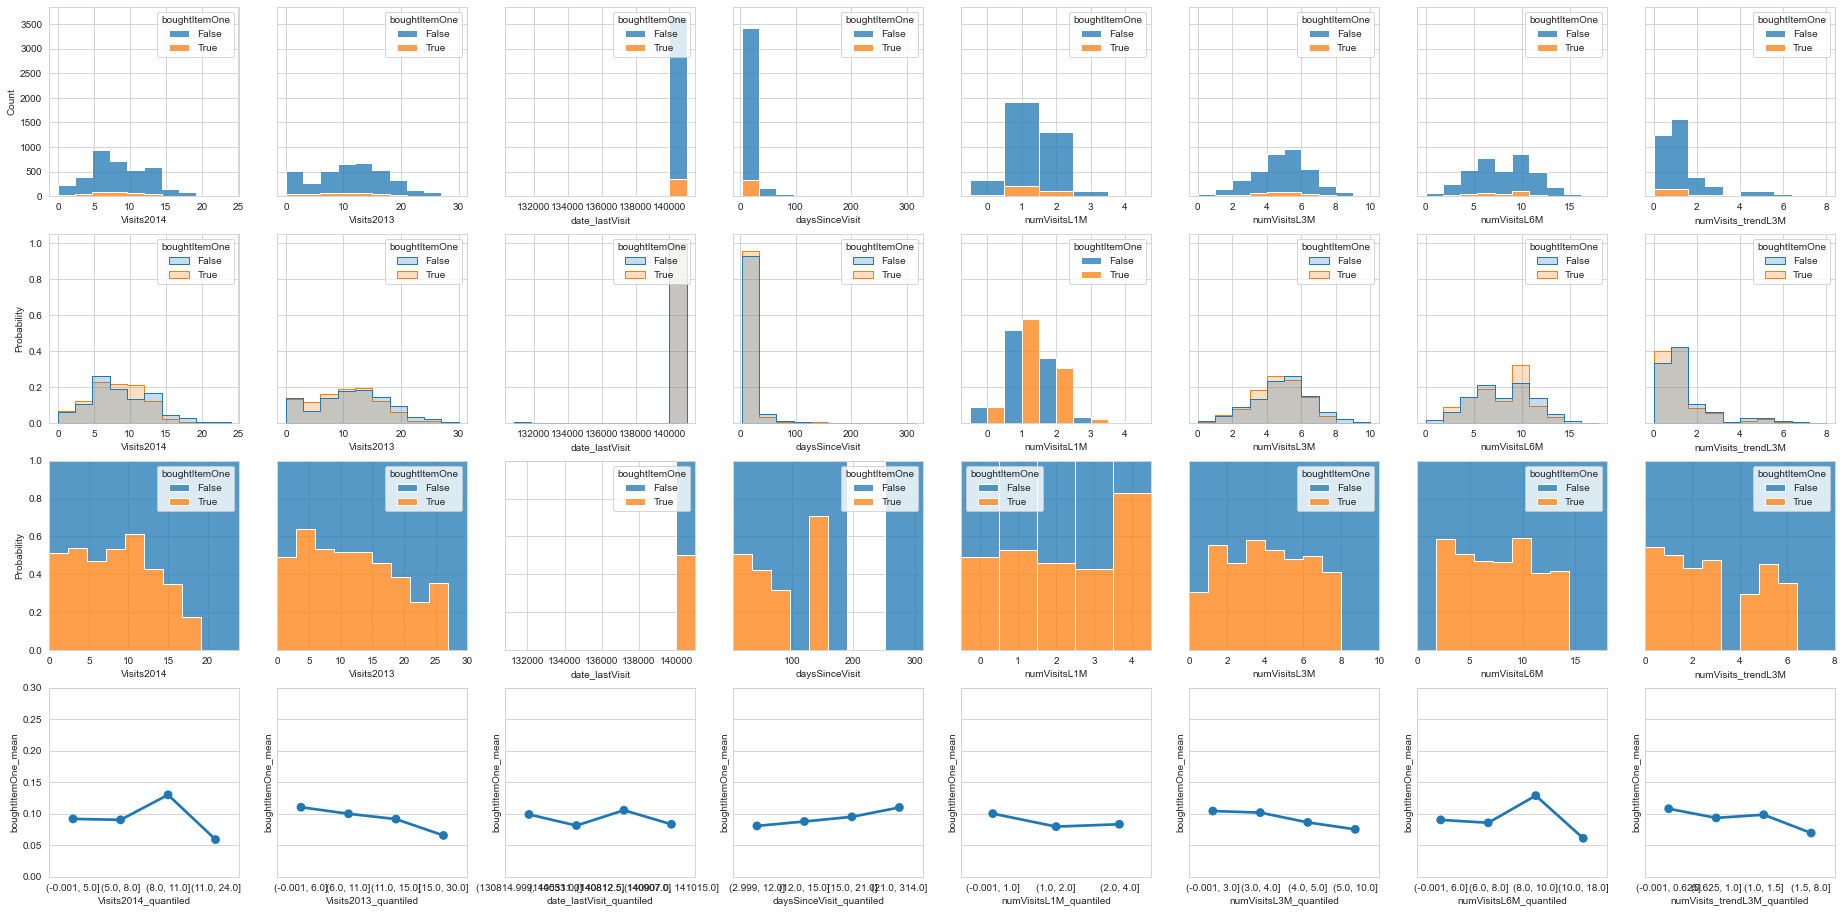

In [24]:
plot_distributions(df, cols)

* No variables stick out obviously here to me.

### 4. Fractions of having bought certain items

In [25]:
cols = [c for c in df.columns if 'fraction' in c.lower()] + ['numItemOne_trendL3M']
fraction_cols = cols
print(len(cols))
cols

7


['fractionItemOneL1M',
 'fractionItemOneTwoThreeL1M',
 'fractionItemOneL3M',
 'fractionItemOneTwoThreeL3M',
 'fractionItemOneL6M',
 'fractionItemOneTwoThreeL6M',
 'numItemOne_trendL3M']

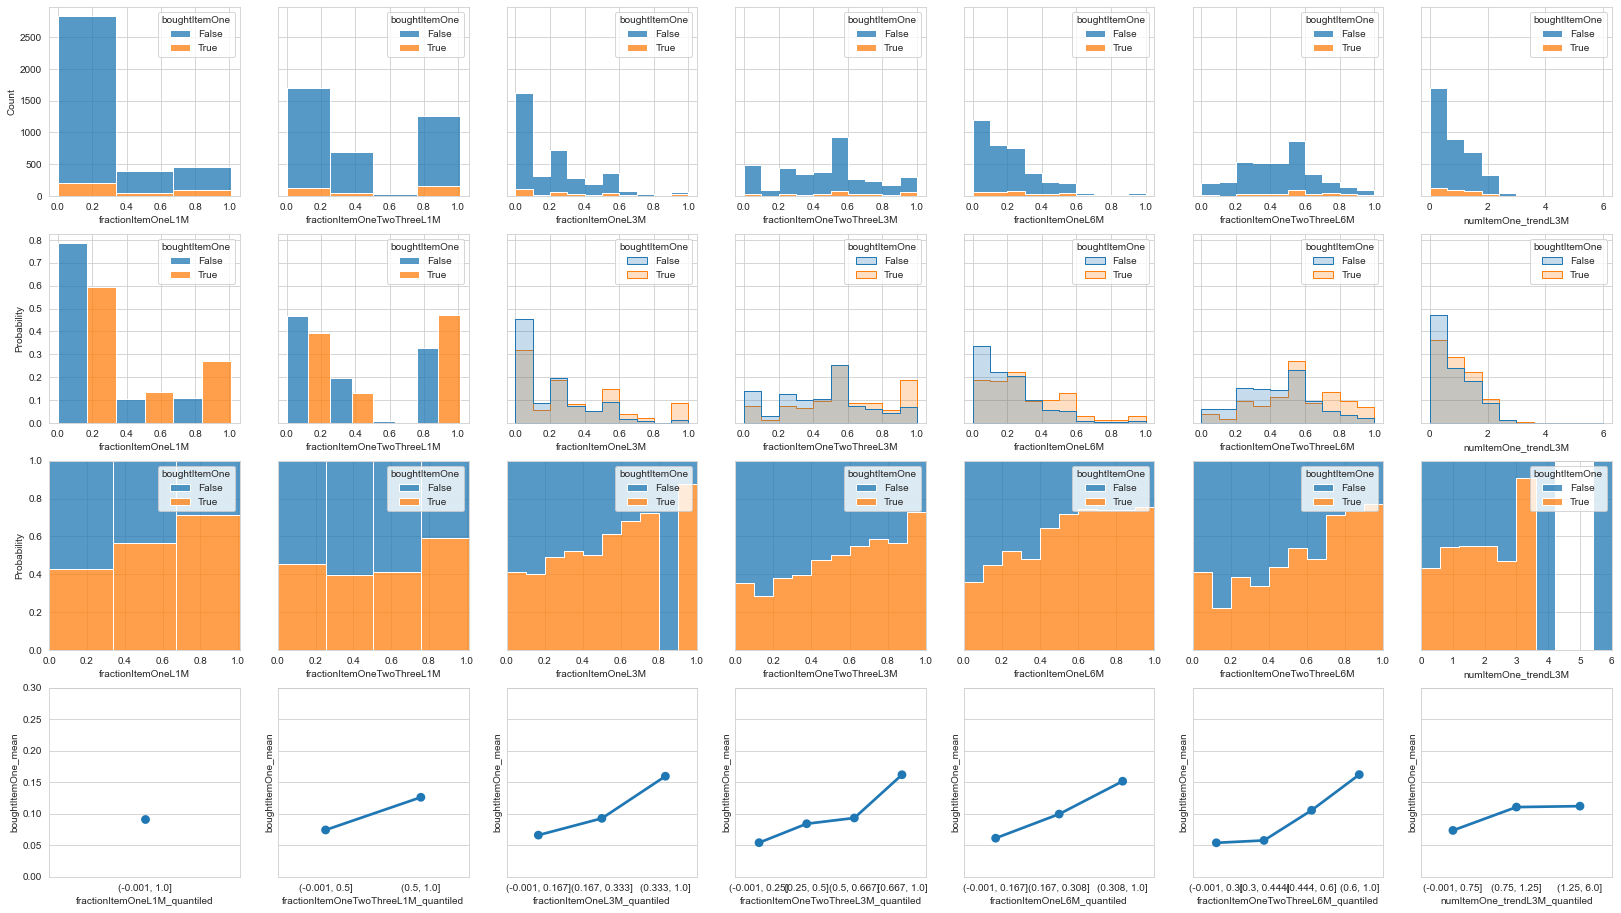

In [26]:
plot_distributions(df, cols)

* Here the conditional distributions are different, indicating these are useufl features. Also, a general trend is that the higher fractions, the higher mean target value (the itemOne fractions don't stick out in this sense).

### 5. Preferences for certain items

In [27]:
cols = [c for c in df.columns if 'preference' in c.lower()]
pref_cols = cols
print(len(cols))
cols

2


['preferenceItemOne', 'preferenceItemOneTwoThree']

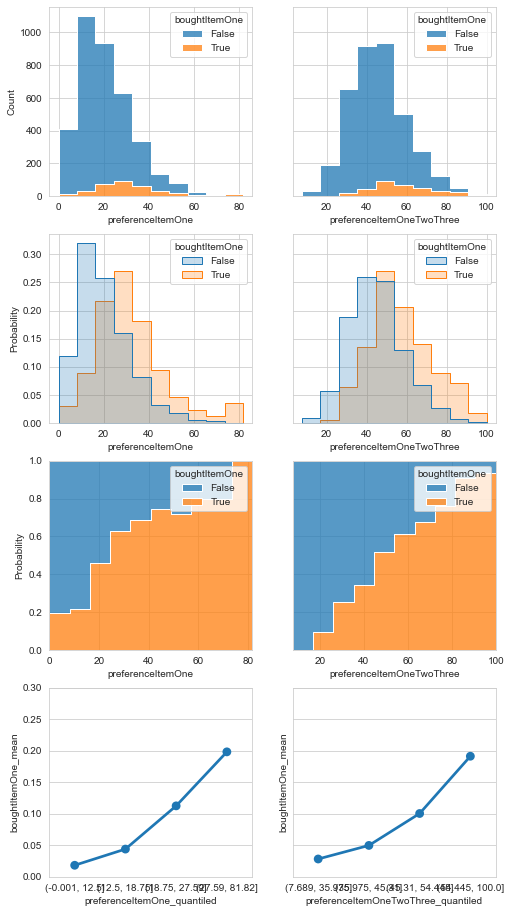

In [28]:
plot_distributions(df, cols)

### 6. Items bought in past visits

In [29]:
cols = [c for c in df.columns if 'boughtitem_' in c.lower()]
bought_cols = cols
print(len(cols))
cols

3


['boughtItem_03', 'boughtItem_02', 'boughtItem_01']

These are categorical (same as target) and there is no numerically meaningful order.

In [30]:
categories = set.union(*[set(df[c].values) for c in cols])

def sort_fn(s):
    try:
        return float(s)
    except:
        return 100

categories = sorted(categories, key=sort_fn)
print(categories)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '10', '11', '12', 'str', 'd', 'k']


In [31]:
# Change the type of these columns in the dataframe.
# Helps automated plotting with seaborn.
categorical_cols = cols + ['boughtItem']  # Add original target variable
assert set(df['boughtItem'].unique()).issubset(set(categories))

In [32]:
for c in categorical_cols:
    assert df[c].dtype == 'object'
    df[c] = pd.Categorical(df[c],categories=categories,ordered=True)

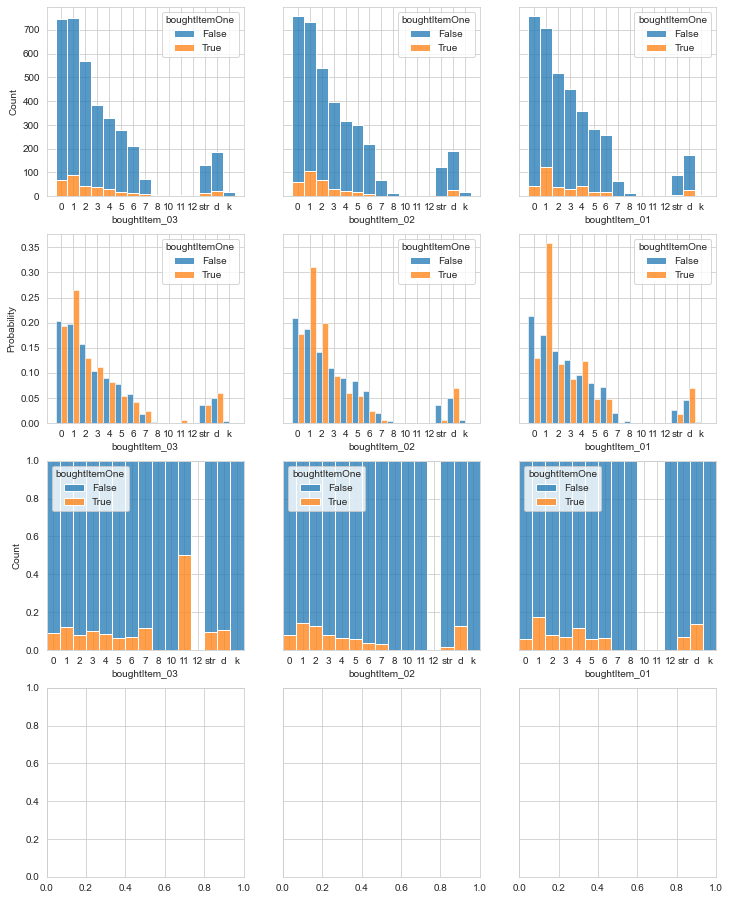

In [33]:
plot_distributions(df, cols)

* Looks like there is some aggregation over time? But I don't understand what the *bought_itemX* variables correspond to.
* To decrease the number of categories, I would also here make these binary.
* Note: there is no natural order here, but to compare things there should be some order added.
* The values 'd', 'k' and 'str' are somewhat surprising, but I'll have to assume here that it corresponds to some item-buying category (could be typo, but it's not obvious).
* I guess that item '0' corresponds to no purchase although it could correspond to any item

# Modeling setup

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from scipy.stats import uniform
import warnings
from sklearn.exceptions import ConvergenceWarning

## Cross-validation config

In [35]:
# Cross-validation config
# TODO: consider multiple repeats? Stratified?
n_splits = 10
cv = KFold(n_splits=n_splits, shuffle=True, random_state=0)

Due to the class-imbalance I use the area under the ROC curve AUC ROC as a scoring metric rather than accuracy. ROC AUC is independent of the threshold for making the classification from on the predicted probabilities.

In [36]:
# scoring = 'neg_log_loss'
scoring = 'roc_auc'
assert scoring in sklearn.metrics.SCORERS.keys()

## Metrics and evaluation

In [37]:
import sklearn.metrics as metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [38]:
def f1_fcn(precision, recall):
    return 2*precision*recall/(precision + recall) 

In [38]:
def evaluation_report(clf, X, y, **plot_kwargs):
    """Evaluate model on (test) dataset."""
    
    # Model's probability for class 1
    p1 = clf.predict_proba(X)[:,1]

    roc_auc = roc_auc_score(y, p1)
    print(f"ROC AUC: {roc_auc:.3f}")
    
    # ROC curve, as TPR vs 1-FPR.
    fpr, tpr, thresholds_roc = roc_curve(y, p1, pos_label=1)
    fig, ax = plt.subplots(1)
    ax.plot(tpr, 1-fpr, **plot_kwargs)
    ax.set_xlabel('TPR (Recall)')
    ax.set_ylabel('1 - FPR');
    ax.set_title("ROC")

    precision, recall, thresholds = precision_recall_curve(y, p1)

    # Precision-recall curve
    fig, ax = plt.subplots(1)
    ax.plot(recall, precision, **plot_kwargs)
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision');
    ax.set_title("Precision-recall")

    # F1 score as a funciton of thresholds
    f1s = f1_fcn(precision, recall)
    fig, ax = plt.subplots(1)
    ax.plot(thresholds, f1s[:-1], **plot_kwargs);
    ax.set_xlabel('Threshold')
    ax.set_ylabel('F1')

    # Maximize F1 and print out metrics at optimum.
    imax = np.argmax(f1s)
    print("At max F1:")
    print(f"precision: {precision[imax]:.3f} recall: {recall[imax]:.3f}, F1: {f1s[imax]:.3f}, threshold {thresholds[imax]:.3f}")
    
    # Confusion matrix for max F1
    y_pred = predictions(clf, X, y, thresholds[imax])
    display_confusion_matrix(y, y_pred)
    
    # TODO: could return stuff

In [ ]:
def maximize_F1(clf, X, y):
    """Return F1, precision, recall and threshold values when maximizing F1."""
    imax = np.argmax(f1s)
    print("At max F1:")
    print(f"precision: {precision[imax]:.3f} recall: {recall[imax]:.3f}, F1: {f1s[imax]:.3f}, threshold {thresholds[imax]:.3f}")
    
    

In [292]:
def display_confusion_matrix(y_true, y_pred, normalize=None):
    cm = pd.DataFrame(metrics.confusion_matrix(y_true, y_pred, normalize=normalize))
    cm.axes[0].name = "True"
    cm.axes[1].name = "Predicted"
    display(cm)

In [124]:
def predictions(clf, X, y, threshold=0.5):
    probs = clf.predict_proba(X)
    preds = np.array(probs[:,1] > threshold, dtype=int)
    return preds

In [2124]:
def plot_tree(clf, figsize=(16,16), fontsize=10):
    plt.figure(figsize=figsize) 
    sklearn.tree.plot_tree(clf, fontsize=fontsize);

# Logistic regression baselines
To get a baseline and set up the modeling machinery I use logistic regression as a first classifier model. To make it even simpler I also use a 1-d model. Based on the visualiziations, *preferenceItemOne* seems like one of the more promising feature candidates.

## Single-feature

In [351]:
features = ['preferenceItemOne']

In [352]:
X = df[features]
y = df[target]
X.shape, y.shape

((3680, 1), (3680,))

In [353]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, shuffle=True)
x_scaler = MinMaxScaler().fit(X_train)
X_train = x_scaler.transform(X_train)
X_test = x_scaler.transform(X_test)

In [354]:
X_test.shape, X_train.shape

((1104, 1), (2576, 1))

In [355]:
clf = LogisticRegression(random_state=0)

In [356]:
clf.fit(X_train, y_train)

LogisticRegression(random_state=0)

ROC AUC: 0.760
At max F1:
precision: 0.224 recall: 0.726, F1: 0.342, threshold 0.084


Predicted,0,1
True,,
0,692,295
1,33,84


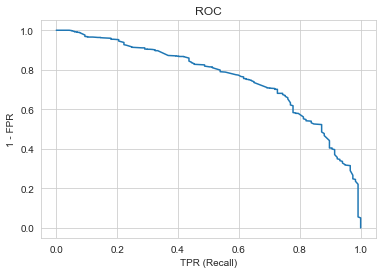

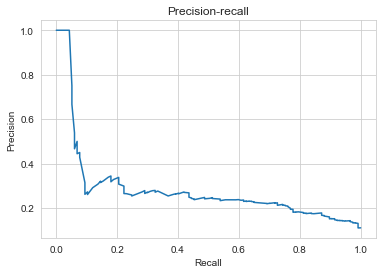

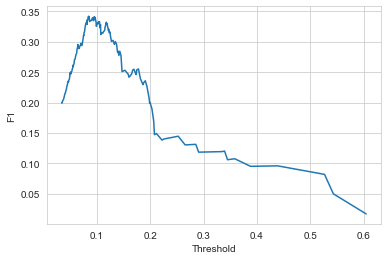

In [357]:
evaluation_report(clf, X_test, y_test)

* Logistic regression achievied 0.76 ROC AUC on only a single variable. This can be used as a first baseline.
* The precision recall curve shows that due to its L-shape for this simple model it's not possible to simultaneously get high precision and recall, which the low F1 score shows.

## All features
We can do same modeling but for all features, just to get an idea whether the other features add anything.

The categorical features needing special preprocessing, I use one-hot encoding, which here leads to ~15 extra binary features per categorical variable. The resulting number if 74 features.

In [358]:
all_cols = (model_cols + count_cols + visit_cols + fraction_cols + pref_cols + bought_cols)
features = all_cols

In [359]:
# Extract features and target
X = pd.get_dummies(df[features])
y = df[target]
X.shape, y.shape

((3680, 74), (3680,))

In [360]:
# Split train/test and do scaling (does not affect one-hot variables)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, shuffle=True)
x_scaler = MinMaxScaler().fit(X_train)
X_train = x_scaler.transform(X_train)
X_test = x_scaler.transform(X_test)

In [361]:
# Quick check: both train and test set have roughly the same proportions of the minority class (~9%)
print(np.sum(y_train), np.mean(y_train), np.sum(y_test), np.mean(y_test),)

223 0.08656832298136646 117 0.10597826086956522


In [362]:
clf = LogisticRegression(random_state=0, max_iter=100)

In [363]:
clf.fit(X_train, y_train)

LogisticRegression(random_state=0)

ROC AUC: 0.825
At max F1:
precision: 0.350 recall: 0.667, F1: 0.459, threshold 0.133


Predicted,0,1
True,,
0,842,145
1,41,76


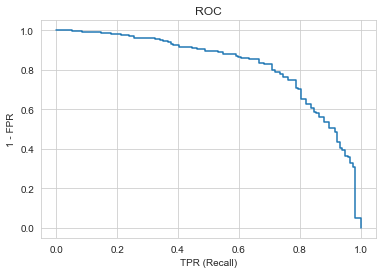

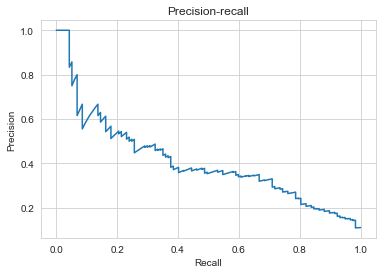

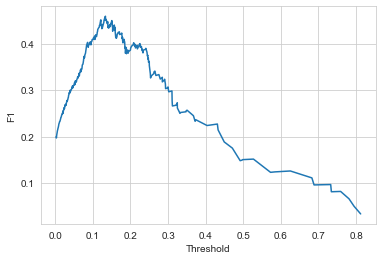

In [364]:
evaluation_report(clf, X_test, y_test)

* Compared to the 1d case, we can achieve better simultaneous precision and recall, and AUC ROC is higher. (To further compare the models even better would be to plot in the same figure.)

# Model and hyperparameter search
Here I more systematically search over the models, the model hyperparameters and different input feature representations.

## Vary models
I consider four different classification models:
* Logistic regression
* K-nearest neighbors
* Decision-tree
* Neural network

In [150]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

In [154]:
# Parameter distributions
from sklearn.utils.fixes import loguniform
from scipy.stats import randint

In [181]:
from sklearn.cluster import KMeans

In [236]:
models = {
    'logistic': LogisticRegression,
    'knn': KNeighborsClassifier,
    'decision-tree': DecisionTreeClassifier,
    'neural-network': MLPClassifier,

}
# Fixed params
params_fixed = {
    'logistic': dict(random_state=0),
    'knn' : dict(),
    'decision-tree': dict(random_state=0),
    'neural-network': dict(random_state=0, max_iter=1000)
}
# Params to sample
params = {
    'logistic': {'C': loguniform(1e-3, 1e1), 'class_weight': (None, 'balanced')},
    'knn': {'n_neighbors': randint(1,50), 'weights': ('uniform', 'distance')},
    'decision-tree': {'max_depth': (1, 3, 5, 7, 9)},
    'neural-network': {'alpha': loguniform(1e-3, 1e1), 
                       'hidden_layer_sizes': [(10,), (100,), (10, 10), (100, 10)],
                       'learning_rate_init': loguniform(1e-3, 1e0)}
}

## Vary input features
I explore a few different options for the input features:
* single-feature: *preferenceOneItem* selected based on visualizations (1-dim)
* all features (74-dim)
* all features but reducing the dimensionality added by the categorical variables by either
    * merging categories "by hand" (38-dim)
    * replacing the categorical features by one cluster categorical feature (32-dim).

In [174]:
# Dict of input features
Xs = {}
# The cols used for each feature combination
Xs_cols = {}

### Single-feature

In [175]:
name = '1-dim'
features = ['preferenceItemOne']
X = pd.get_dummies(df[features])

# Print info and save
print(X.shape)
Xs_cols[name] = features
Xs[name] = X

(3680, 1)


### All features

In [176]:
# Use all variables (excluding target-related)
name = 'all'
features = all_cols
X = pd.get_dummies(df[features])

# Print info and save
print(X.shape)
Xs_cols[name] = features
Xs[name] = X

(3680, 74)


### All feaures, merged categorical

In [177]:
# Use all features, but reduce dimensionality added by one-hot encoding 
# by for each variable merging bought item categories into "0", "1", "other" 
name = 'bought-01rest'
cols = bought_cols

In [178]:
# Note: probably a better pandas way of doing this...
new_cols = []
for c in cols:
    new_cols_c = [c+'_zero', c+'_one', c+'_other']
    df[c+'_zero'] = (df[c] == '0')
    df[c+'_one'] = (df[c] == '1')
    df[c+'_other'] = ~(df[c+'_zero'] | df[c+'_one'])
    df[new_cols_c]  = df[new_cols_c].astype(int)

    counts = sum(df[c+'_zero']), sum(df[c+'_one']), sum(df[c+'_other'])
    print(*zip(new_cols_c, counts))
    assert sum(counts) == len(df)
    new_cols += new_cols_c

features = [f for f in all_cols if not f in cols] + new_cols
X = pd.get_dummies(df[features])

# Print info and save
print(X.shape)
Xs_cols[name] = features
Xs[name] = X

('boughtItem_03_zero', 746) ('boughtItem_03_one', 748) ('boughtItem_03_other', 2186)
('boughtItem_02_zero', 758) ('boughtItem_02_one', 732) ('boughtItem_02_other', 2190)
('boughtItem_01_zero', 758) ('boughtItem_01_one', 706) ('boughtItem_01_other', 2216)
(3680, 38)


In [180]:
Xs.keys(), Xs_cols.keys()

(dict_keys(['1-dim', 'all', 'bought-01rest']),
 dict_keys(['1-dim', 'all', 'bought-01rest']))

### All features, cluster on categorical

In [211]:
# Use all features, but reduce dimensionality added by one-hot encoding 
# by clustering customers into 3 clusters based on what items they bought (in the past).
name = 'bought-kmeans'

In [183]:
# First need to "learn" the clusters
X = pd.get_dummies(df[bought_cols])

In [184]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, shuffle=True)
x_scaler = MinMaxScaler().fit(X_train)
X_train = x_scaler.transform(X_train)
X_test = x_scaler.transform(X_test)

In [185]:
kclustering = KMeans(n_clusters=3, random_state=0).fit(X_train)

In [212]:
new_col = 'bought-cluster'

In [198]:
# Add cluster index as a new feature
df[new_col] = pd.Categorical(kclustering.predict(X).astype(str))

Below we see:
* Cluster '0' is the most populated cluster.
* Cluster '1' seems to have somewhat higher tendency to buy item one.

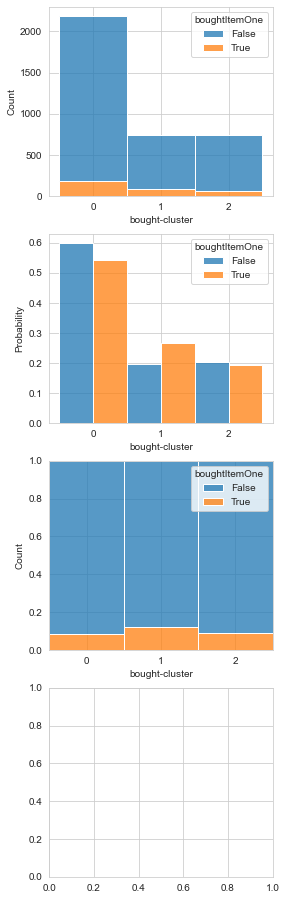

In [210]:
plot_distributions(df, [new_col])

In [219]:
features = [c for c in all_cols if c not in bought_cols] + [new_col]
X = pd.get_dummies(df[features])

# Print info and save
print(X.shape)
Xs_cols[name] = features
Xs[name] = X

(3680, 32)


## Perform the search

In [271]:
params

{'logistic': {'C': <scipy.stats._distn_infrastructure.rv_frozen at 0x1532f6a60>,
  'class_weight': (None, 'balanced')},
 'knn': {'n_neighbors': <scipy.stats._distn_infrastructure.rv_frozen at 0x152fd2370>,
  'weights': ('uniform', 'distance')},
 'decision-tree': {'max_depth': (1, 3, 5, 7, 9)},
 'neural-network': {'alpha': <scipy.stats._distn_infrastructure.rv_frozen at 0x152fd22b0>,
  'hidden_layer_sizes': [(10,), (100,), (10, 10), (100, 10)],
  'learning_rate_init': <scipy.stats._distn_infrastructure.rv_frozen at 0x1532e33d0>}}

In [298]:
search_results = {}
n_iter = 20
for x_name, X in Xs.items():
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    x_scaler = MinMaxScaler().fit(X_train)
    X_train = x_scaler.transform(X_train)
    X_test = x_scaler.transform(X_test)
    for model_name, model_cls in models.items():
        clf = model_cls(**params_fixed[model_name])
        key = (model_name, x_name)
        print(key)
        search = RandomizedSearchCV(clf, param_distributions=params[model_name],
                                    scoring=scoring, cv=cv, verbose=1, random_state=0, n_iter=n_iter)
        # Ignore warnings from combinations that don't converge
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
            search_results[key] = search.fit(X_train, y_train.ravel())

('logistic', '1-dim')
Fitting 10 folds for each of 20 candidates, totalling 200 fits
('knn', '1-dim')
Fitting 10 folds for each of 20 candidates, totalling 200 fits
('decision-tree', '1-dim')
Fitting 10 folds for each of 5 candidates, totalling 50 fits
('neural-network', '1-dim')
Fitting 10 folds for each of 20 candidates, totalling 200 fits


/Users/viveca/.local/share/virtualenvs/case_study-ujeuPog0/lib/python3.8/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 5 is smaller than n_iter=20. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


('logistic', 'all')
Fitting 10 folds for each of 20 candidates, totalling 200 fits
('knn', 'all')
Fitting 10 folds for each of 20 candidates, totalling 200 fits
('decision-tree', 'all')
Fitting 10 folds for each of 5 candidates, totalling 50 fits


/Users/viveca/.local/share/virtualenvs/case_study-ujeuPog0/lib/python3.8/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 5 is smaller than n_iter=20. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


('neural-network', 'all')
Fitting 10 folds for each of 20 candidates, totalling 200 fits
('logistic', 'bought-01rest')
Fitting 10 folds for each of 20 candidates, totalling 200 fits
('knn', 'bought-01rest')
Fitting 10 folds for each of 20 candidates, totalling 200 fits
('decision-tree', 'bought-01rest')
Fitting 10 folds for each of 5 candidates, totalling 50 fits


/Users/viveca/.local/share/virtualenvs/case_study-ujeuPog0/lib/python3.8/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 5 is smaller than n_iter=20. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


('neural-network', 'bought-01rest')
Fitting 10 folds for each of 20 candidates, totalling 200 fits
('logistic', 'bought-kmeans')
Fitting 10 folds for each of 20 candidates, totalling 200 fits
('knn', 'bought-kmeans')
Fitting 10 folds for each of 20 candidates, totalling 200 fits
('decision-tree', 'bought-kmeans')
Fitting 10 folds for each of 5 candidates, totalling 50 fits


/Users/viveca/.local/share/virtualenvs/case_study-ujeuPog0/lib/python3.8/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 5 is smaller than n_iter=20. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


('neural-network', 'bought-kmeans')
Fitting 10 folds for each of 20 candidates, totalling 200 fits


# Results

In [274]:
def top_results(search_results):
    """Return the best result of each search.
    
    Returns sorted dict, highest scoring first.
    """
    # TODO; is a bit messy here.
    best_results = dict()
    for name, search in search_results.items():
        means, stds, params = [search.cv_results_[x] for x in ('mean_test_score', 'std_test_score', 'params')]
        means_stds_params_sorted = sorted(zip(means, stds, params), key=(lambda t: t[0]), reverse=True)
        first = means_stds_params_sorted[0]
        mean, std, params = first
        best_results[name] = mean, std, params
    best_results = dict(sorted(best_results.items(), key=lambda x: x[1][0], reverse=True))
    return best_results

In [299]:
best_results = top_results(search_results)

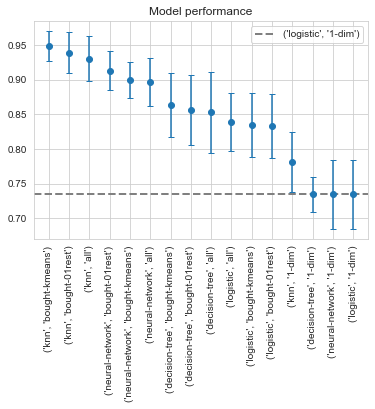

In [300]:
# Plot the best results
# Pick the simplest model as baseline
# TODO: could rotate this plot.
baseline = ('logistic', '1-dim')
baseline_val = best_results[baseline][0]
plt.axhline(baseline_val, linestyle='--', color='gray', linewidth=2, label=baseline)
plt.legend()
labels=[]
for i, label in enumerate(best_results):
    mae, std = best_results[label][:2]
    plt.errorbar(i, mae, yerr=std, color='C0', marker='o', capsize=3)
    labels.append(label)
plt.xticks(np.arange(len(labels)), labels, rotation=90);
plt.ylabel('');
plt.title("Model performance");

* Note: the error bars are the standard deviation of the cross-validation scores.

In [342]:
# Also dump the result info
print(*best_results.items(), sep='\n')

(('knn', 'bought-kmeans'), (0.9493121492500698, 0.021321250703968984, {'n_neighbors': 45, 'weights': 'distance'}))
(('knn', 'bought-01rest'), (0.9393257278553898, 0.03009288805441435, {'n_neighbors': 45, 'weights': 'distance'}))
(('knn', 'all'), (0.9306844542057524, 0.032619512186620285, {'n_neighbors': 45, 'weights': 'distance'}))
(('neural-network', 'bought-01rest'), (0.9130708925681826, 0.028283012085994732, {'alpha': 0.037251107093913986, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.0016334587611069493}))
(('neural-network', 'bought-kmeans'), (0.8998299309846608, 0.026033622749402446, {'alpha': 0.037251107093913986, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.0016334587611069493}))
(('neural-network', 'all'), (0.8964051649623734, 0.034793477934025326, {'alpha': 0.0022310905607443037, 'hidden_layer_sizes': (100, 10), 'learning_rate_init': 0.012726958252506759}))
(('decision-tree', 'bought-kmeans'), (0.8638579337294156, 0.045794861964331156, {'max_depth': 9}))
(('d

A few observations:
* The choice model is  more important than the choice features, except when the features are the one-dimensional one, *1-dim*. The ranking of the models is: 
    *knn*, *neural-network*, *decision-tree*, *logistic*. Note that the same ranking holds also when *1-dim* was chosen as input.
* The reduced dimensionality features (*bought-kmeans* and *bought-01rest*) generally performs slightly better than *all*, except for *logistic*.
* For *knn*, the optimized parameters for the higher-dimensional features converged to 45 neighbors using inverse distance weighting.

## Final evaluation for best model
Here "best" is defined as highest AUC ROC.

In [343]:
first = list(best_results)[0]
best_params = best_results[first][-1]
model_name, x_name = first
print(model_name, x_name, best_params)

knn bought-kmeans {'n_neighbors': 45, 'weights': 'distance'}


In [344]:
clf = models[model_name](**params_fixed[model_name], **best_params)
print(clf)

KNeighborsClassifier(n_neighbors=45, weights='distance')


In [345]:
X = Xs[x_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
x_scaler = MinMaxScaler().fit(X_train)
X_train = x_scaler.transform(X_train)
X_test = x_scaler.transform(X_test)

In [346]:
clf.fit(X_train, y_train)
# Plot the training curve if possible
# (could plot tree structure)
if hasattr(clf, 'loss_curve_'):
    fig, ax = plt.subplots(1)
    ax.plot(clf.loss_curve_)
    ax.set_xlabel('Training iterations')
    ax.set_ylabel(clf.loss_)

ROC AUC: 0.967
At max F1:
precision: 1.000 recall: 0.744, F1: 0.853, threshold 0.290


Predicted,0,1
True,,
0,987,0
1,32,85


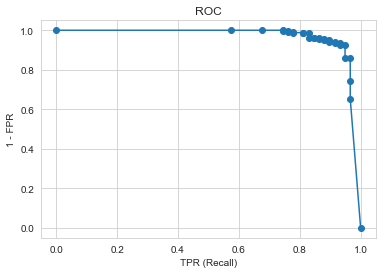

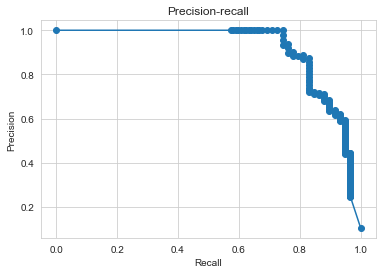

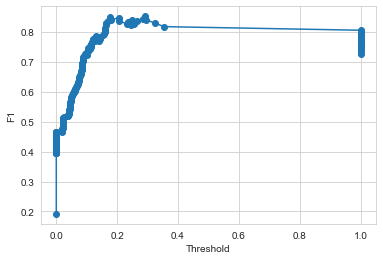

In [347]:
# Evaluate on test set
evaluation_report(clf, X_test, y_test, marker='o')

# Summary
- Classification models were evaluated for predicting whether item one will be bought or not by a customer, given certain historical input features.
- A search over model types with hyperparameters and input features was carried out using a randomized search. AUC ROC was used as a scoring metric.
- **Result:** the best scoring model was k-nearest neighbors achieving ROC AUC: 0.967 and maximal F1: 0.853 (precision: 1.000 recall: 0.744).

# Outlook
The continuation of this work has several avenues.
-  Understand better the requirements of the model, e.g. in terms of precision vs recall. Use to further choose and optimize the model.
-  Error analysis: when are errors made?
-  More feature engineering/dimensionality reduction techniques and understand the input better. Apply e.g. clustering, PCA analysis, add polynomial terms?
-  Effects of class imbalance, do oversampling techniques improve performance?